In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.evaluation import *
from decode_fish.funcs.plotting import *
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader
from decode_fish.engine.microscope import Microscope
from decode_fish.engine.model import UnetDecodeNoBn
import shutil
from torch.utils.tensorboard import SummaryWriter
from decode_fish.engine.point_process import PointProcessUniform
from decode_fish.engine.gmm_loss import PointProcessGaussian

from decode_fish.funcs.visualization import *
from decode_fish.funcs.routines import *

import ipyvolume as ipv

base_path =  '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/'

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

# Training

Load base config

In [4]:
early = load_tiff_image(base_path + '/datasets/CodFish/smFISH_data_Titlow/COVID/972503_early_infection.tif')
late = load_tiff_image(base_path + '/datasets/CodFish/smFISH_data_Titlow/COVID/972462_late_infection.tif')

In [5]:
from tifffile import imsave
imsave(base_path + '/datasets/CodFish/smFISH_data_Titlow/COVID/early.tif', data=cpu(early.transpose(0,1))[:1])
imsave(base_path + '/datasets/CodFish/smFISH_data_Titlow/COVID/late.tif', data=cpu(late.transpose(0,1))[:1])

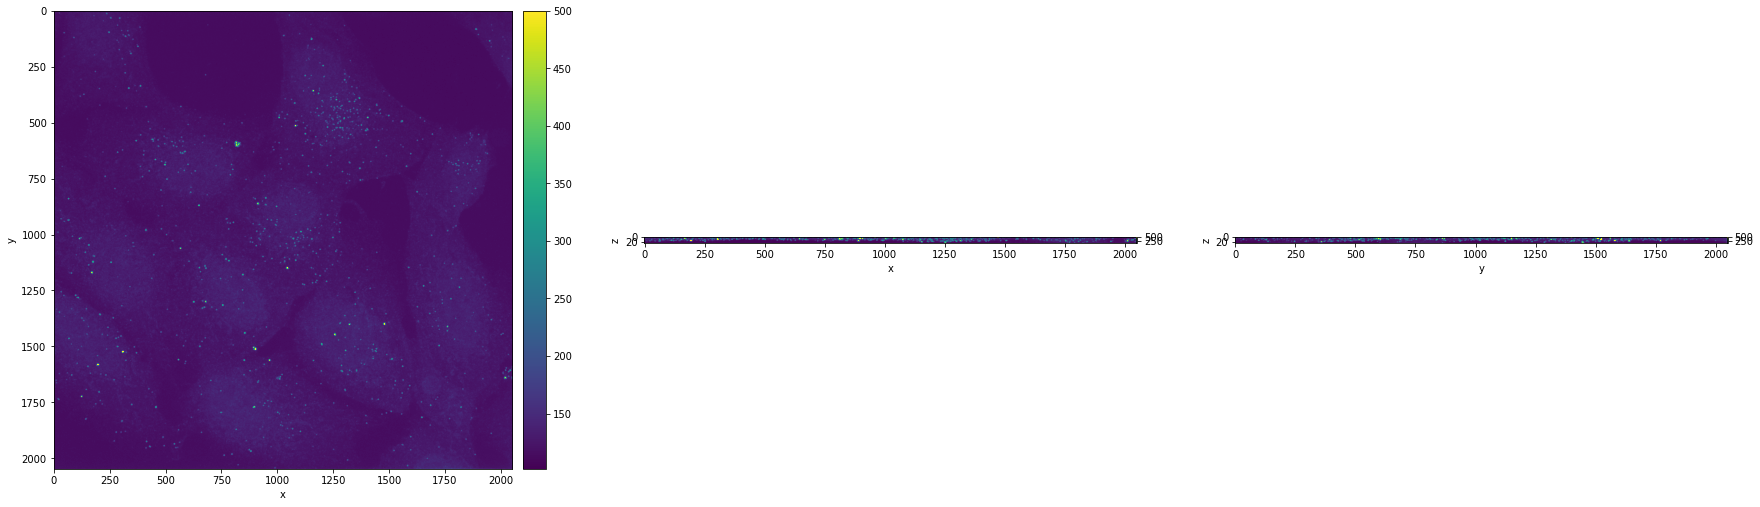

In [6]:
_ = plot_3d_projections(early[:,1,:,:], 'max', size=10, vmax=500)

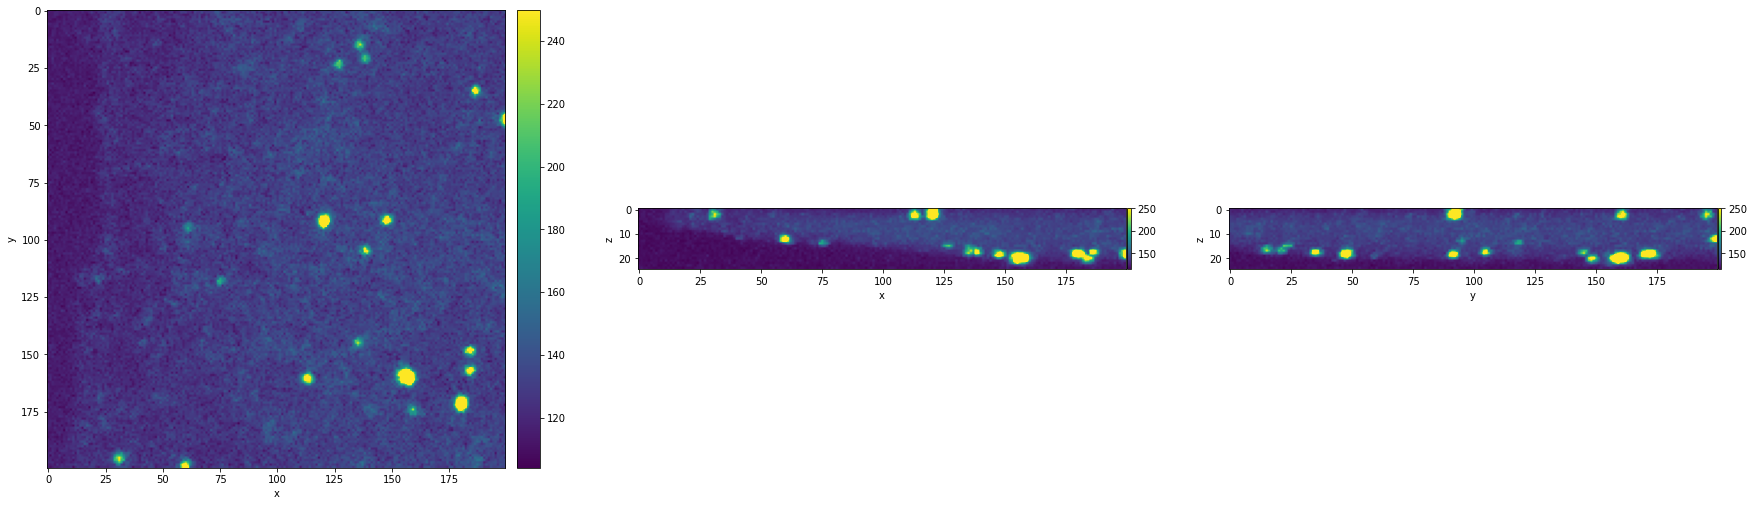

In [7]:
_ = plot_3d_projections(early[:,1,200:400,1000:1200], 'max', size=10, vmax=250)

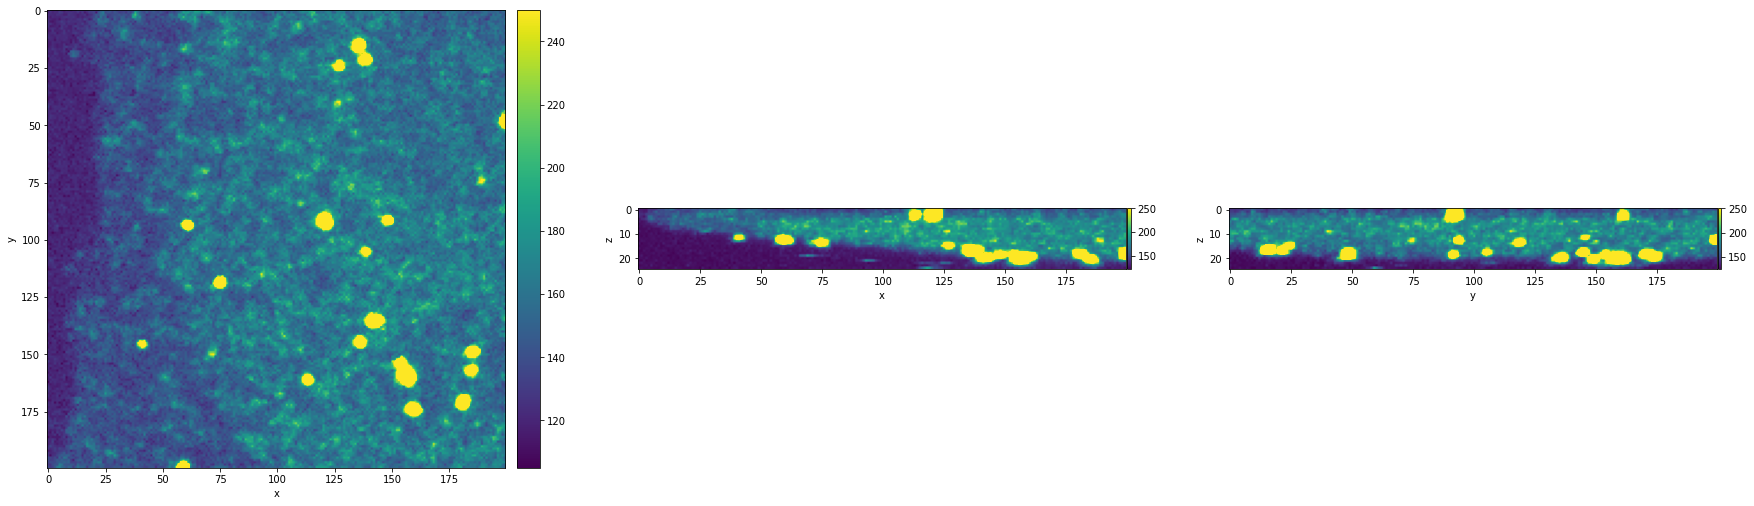

In [8]:
_ = plot_3d_projections(early[:,0,200:400,1000:1200], 'max', size=10, vmax=250)

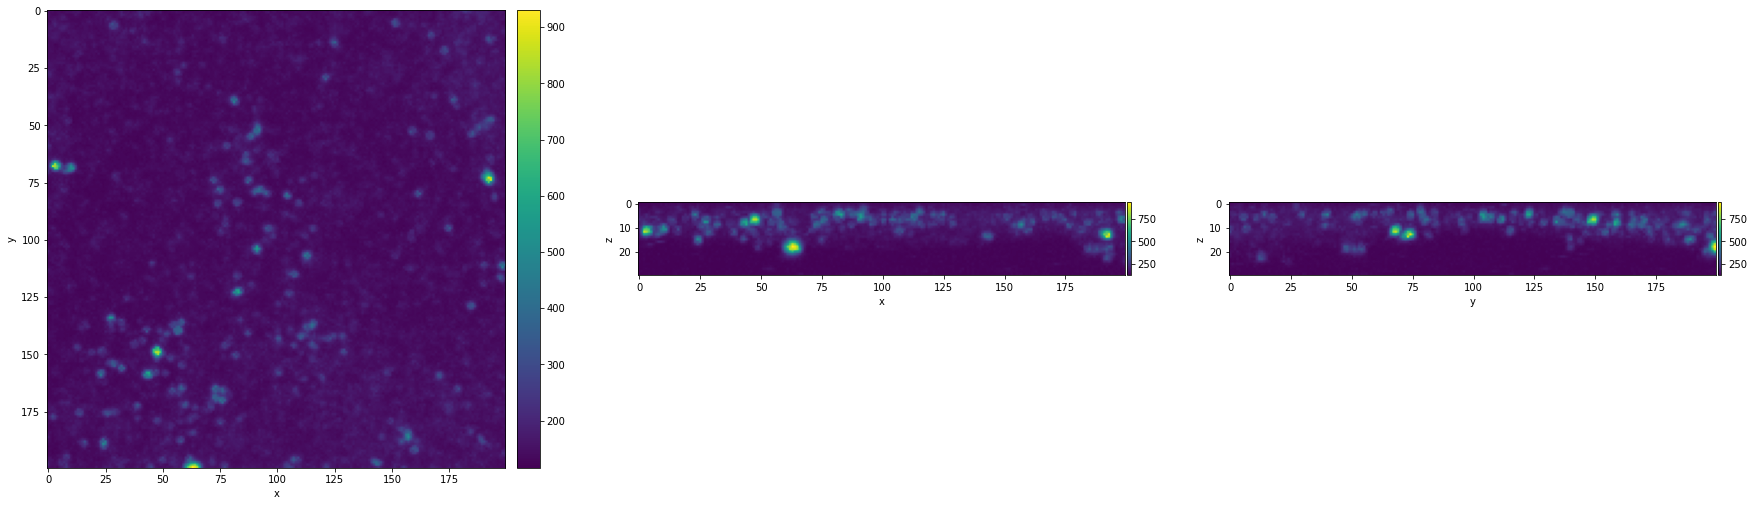

In [9]:
_ = plot_3d_projections(late[:,1,800:1000,200:400], 'max', size=10)

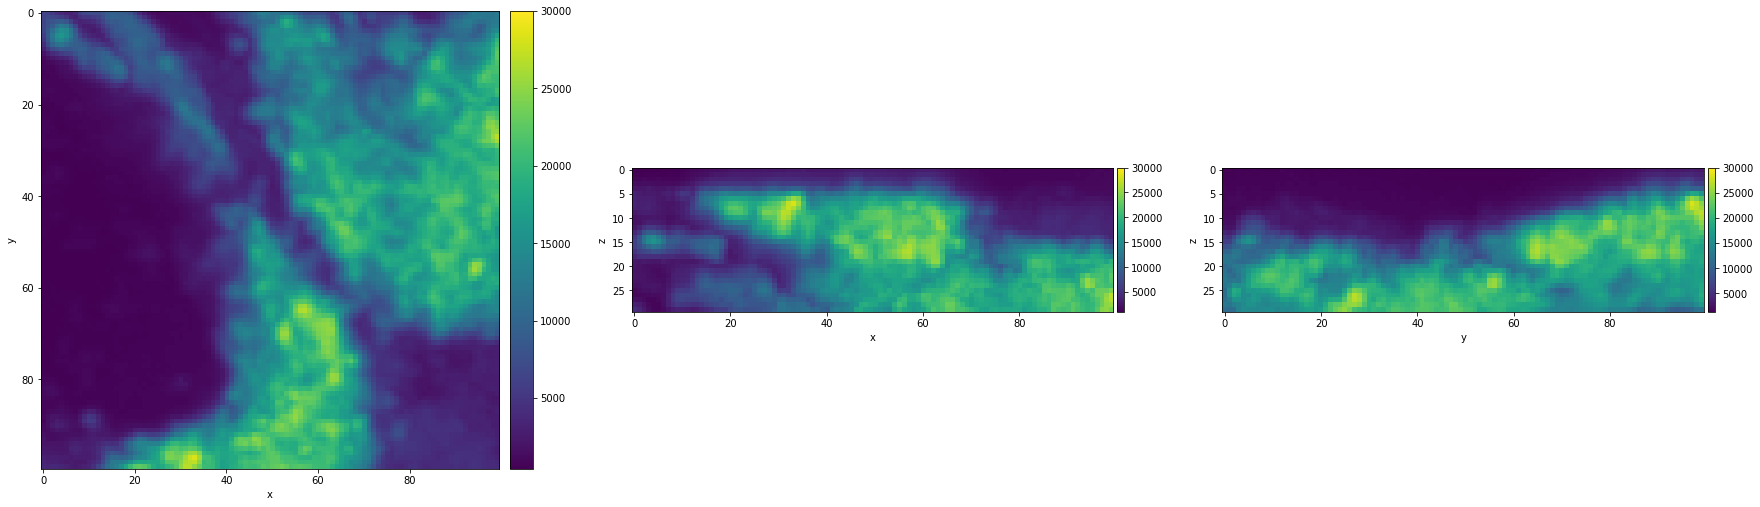

In [10]:
_ = plot_3d_projections(late[:,1,100:200,50:150], 'max', size=10, vmax=30000)

In [27]:
cfg = OmegaConf.load('config/train.yaml')

Make dataset specific changes

In [28]:
cfg.output.project = 'covid_late'

cfg.run_name ='covid_late_smFISH_1'
cfg.data_path.image_path = base_path + '/datasets/CodFish/smFISH_data_Titlow/COVID/late.tif'
cfg.data_path.psf_path = None
cfg.ground_truth = None

cfg.bg_estimation._target_ = 'decode_fish.funcs.dataset.UniformBackground'
cfg.bg_estimation.min_bg = 100
cfg.bg_estimation.max_bg = 500

cfg.foci.n_foci_avg = 4
cfg.foci.n_mol_range: [3,50]

cfg.evaluation.txt_path = None
cfg.evaluation.crop_sl = 's_[:,:,200:300,100:200]'
cfg.evaluation.px_size_zyx =  [100,100,100]

cfg.model.int_conc = 5.
cfg.model.int_rate = 1.
cfg.model.int_loc = .5
cfg.microscope.scale = 10

cfg.PSF.gauss_radii = [1.5,1.5,1.5]
cfg.PSF.psf_extent_zyx = [25,25,25]

cfg.prob_generator.low= 0.000001
cfg.prob_generator.high= 0.025

cfg.noise.theta = 2.
cfg.noise.baseline = 0.

cfg.training.num_iters = 30000
cfg.training.start_micro = 3000
cfg.training.start_psf = 3000

Store the config as an experiment

In [29]:
OmegaConf.save(cfg, f'config/experiment/{cfg.run_name}.yaml')

In [14]:
img_3d, decode_dl = get_dataloader(cfg)
psf, noise, micro = load_psf_noise_micro(cfg)

Crop size larger than volume in at least one dimension. Crop size changed to (30, 48, 48)
1 volumes


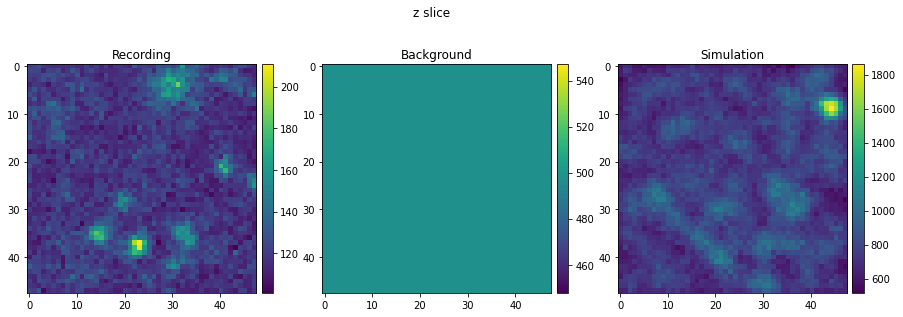

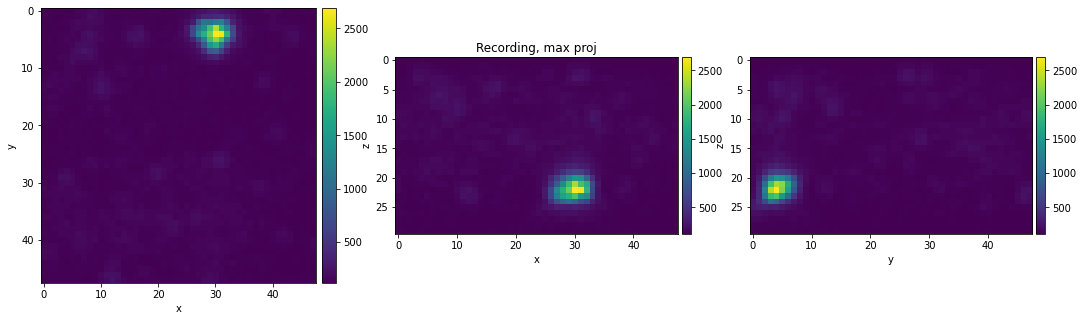

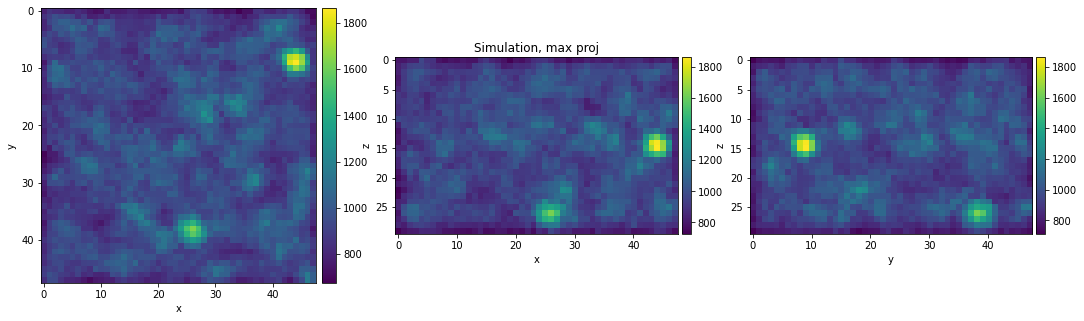

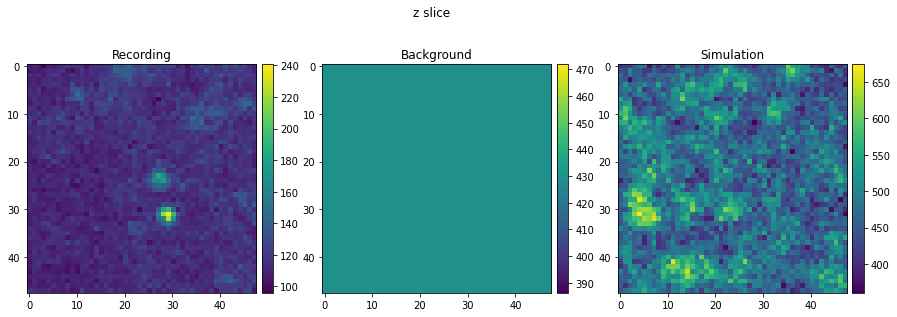

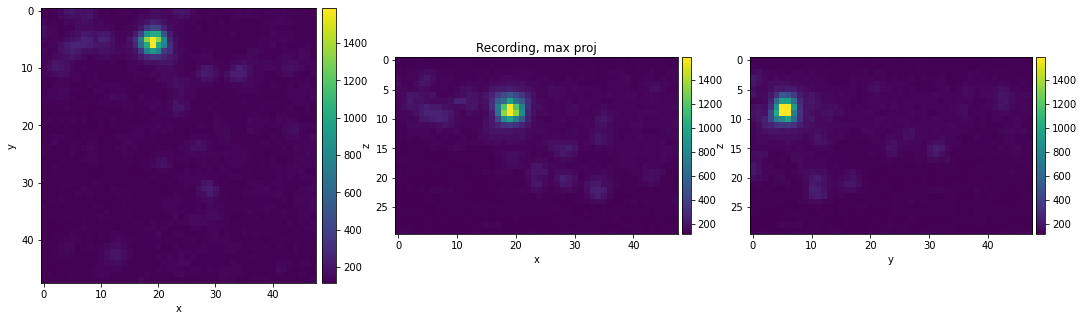

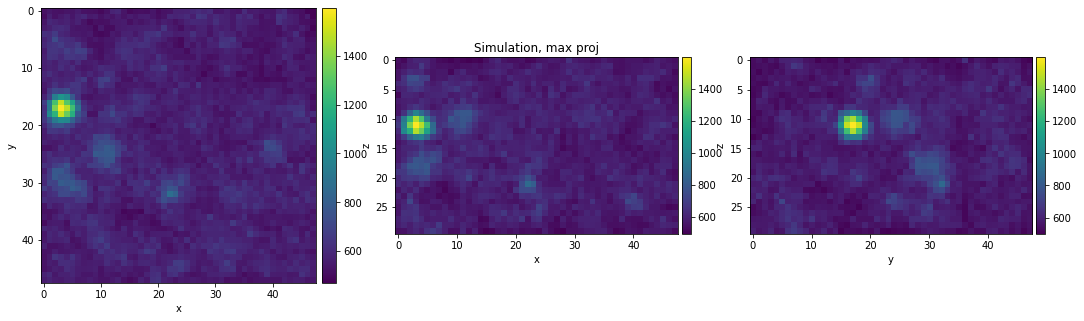

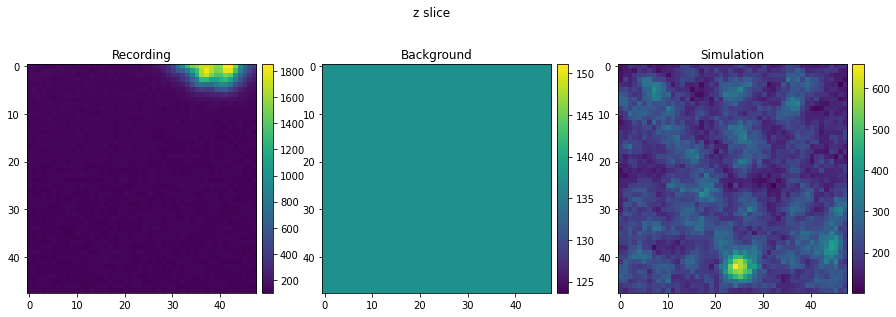

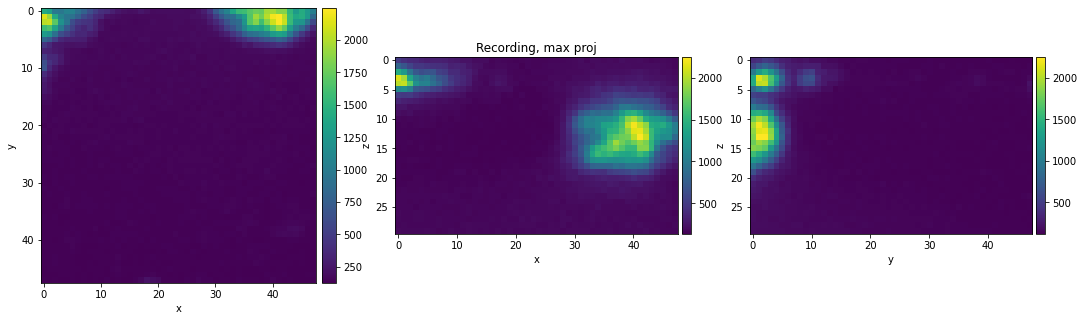

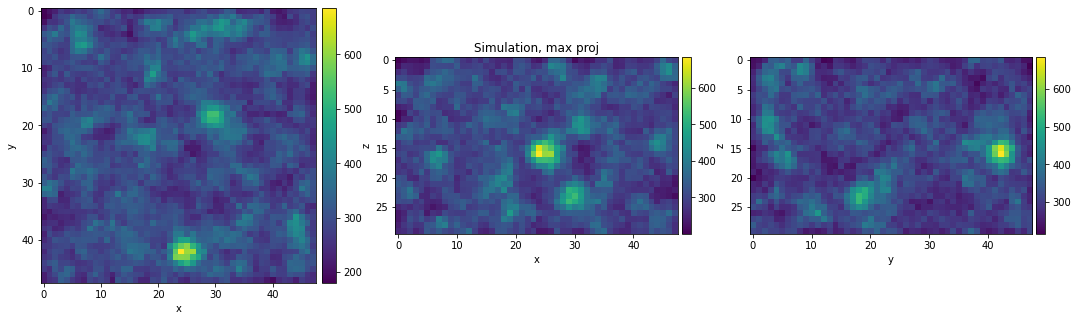

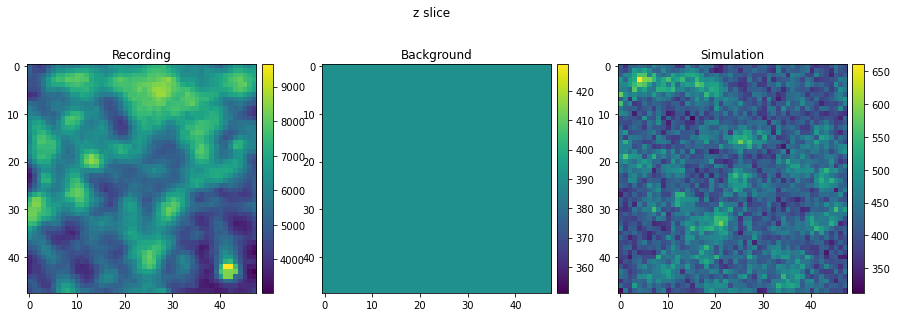

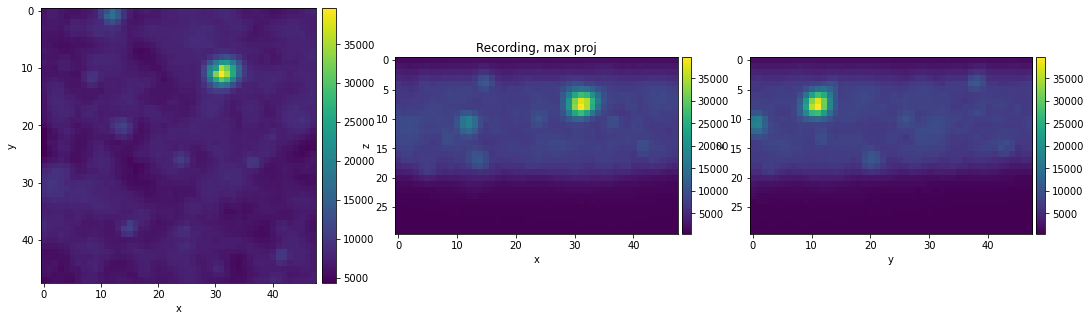

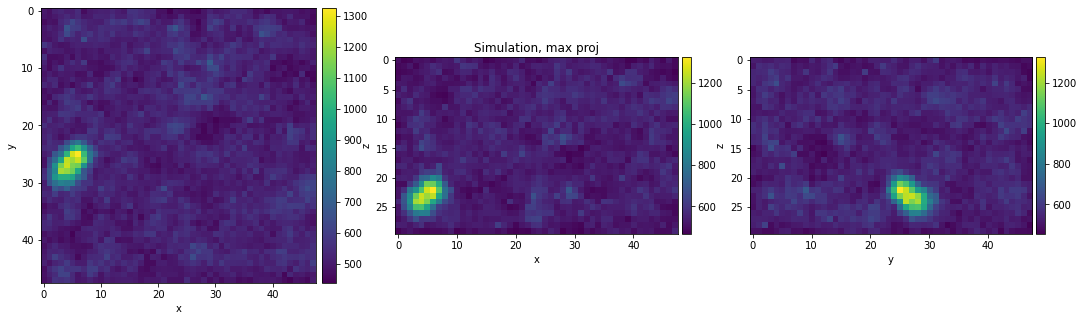

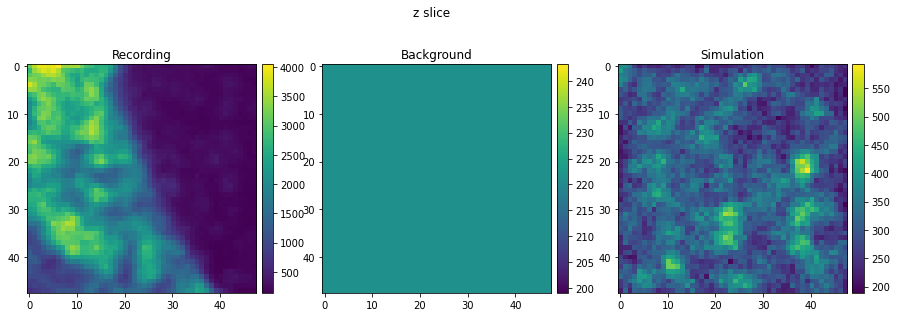

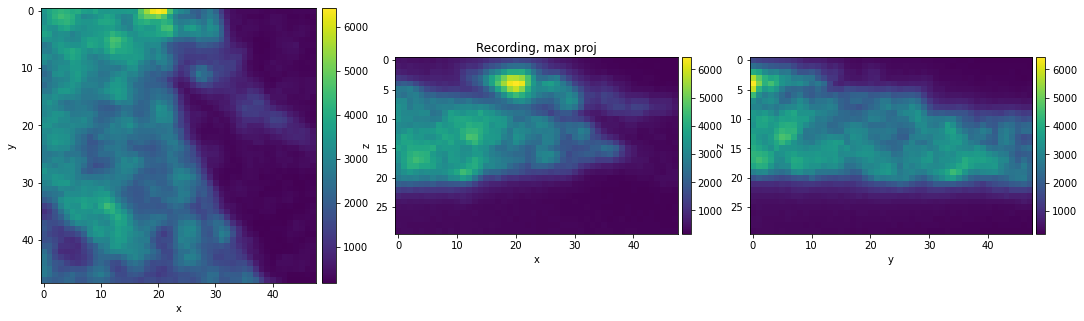

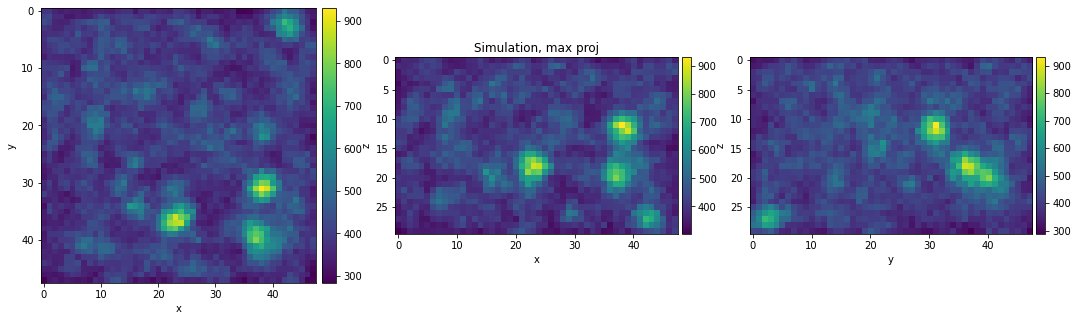

In [15]:
get_simulation_statistics(decode_dl, micro, **cfg.intensity_dist, int_threshold=10, samples=5)

Plot projections of the volume

In [ ]:
crop_sl = eval(cfg.evaluation.crop_sl,{'__builtins__': None},{'s_': np.s_})
_ = plot_3d_projections(img_3d[cfg.evaluation.img_ind][crop_sl[1:]], 'max', vmax=300)

Plot a sample from our dataloader showing a slice from the input volume and from a simulated training volume

Command to train a model on the gpu cluster

In [22]:
home_dir = os.getenv("HOME")
f'bsub -gpu "num=1" -q gpu_any -o {home_dir}/logs/ofish.log -e {home_dir}/logs/efish.log {home_dir}/anaconda3/envs/decode2_dev/bin/python {home_dir}/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment={cfg.run_name}'

'bsub -gpu "num=1" -q gpu_any -o /groups/turaga/home/speisera/logs/ofish.log -e /groups/turaga/home/speisera/logs/efish.log /groups/turaga/home/speisera/anaconda3/envs/decode2_dev/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment=covid_late_smFISH_1'

# Evaluation

In [ ]:
cfg = OmegaConf.load(f'config/experiment/covid_early_smFISH_4.yaml')
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/covid_early//sweep_4/int_conc:5.0/train.yaml')
# cfg.run_name = 'rab11_nb'
# cfg.data_path.image_path = base_path + '/datasets/CodFish/smFISH_data_Titlow/rab11_smFISH_4.tif'


In [ ]:
model, post_proc, psf, micro, img_3d, decode_dl = load_all(cfg, False)
psf_init = get_gaussian_psf(cfg.PSF.psf_extent_zyx,cfg.PSF.gauss_radii)
psf_init = cpu(psf_init.psf_volume[0])
psf_vol = cpu(psf.psf_volume[0])

In [ ]:
img_3d, decode_dl = get_dataloader(cfg)

In [ ]:
sl = np.s_[:,:,600:800,400:600]
axes = plot_3d_projections(img_3d[0][sl[1:]], size=15, vmax=200)

axes = plot_3d_projections(img_3d[0][sl[1:]], size=15, vmax=200)
scat_3d_projections(axes, [crop_df(pred_df, sl, px_size_zyx=[100,100,100])], px_size_zyx=[100,100,100])

In [ ]:
plt.hist(pred_df['int'])

In [ ]:
_=plt.hist(pred_df['comb_sig'], bins = np.linspace(0,1,101))

Plot projections of the PSF before and after optimizing it during training

In [ ]:
print(psf.get_com())
plot_3d_projections(psf_vol)
plot_3d_projections(psf_init)
print('Sum: ',  psf_vol.sum(), psf_init.sum())
print('CSum: ', np.clip(psf_vol,0,10).sum(), psf_init.sum())

Sample random sub volumes and overlay them with predictions, also show the reconstructions from applying the microscope and psf model to those predictions

In [ ]:
eval_random_crop(decode_dl, model, post_proc, micro, projection='max', samples=3)

Volume with Foci? Max projection of real volume, reconstruction, difference

In [ ]:
pred_df, gt_rec, res_dict = get_prediction(model,post_proc,img_3d[:,250:350,300:400], micro, return_rec=True, cuda=True, min_int=0.3)
_ = gt_plot(img_3d[:,250:350,300:400][None], pred_df, gt_df=None, px_size=[100,100,100], gt_rec=gt_rec[0])
# torch.save(res_dict, 'data/model_output_r.pt')

In [ ]:
with torch.no_grad():
    model.cpu()
    res = model(img_3d[0][None,None,:,:1250,:1250].to('cpu'))
    pred_df = post_proc(res)
    free_mem()

Inferred intensities

In [ ]:
_ = plt.hist(pred_df['int'], bins=np.linspace(0.2,1,81))
print(len(pred_df))

In [ ]:
def scatter3d_df(df, shape, px_size=[100,100,100], color='red', size=1):
    ipv.scatter(df['x']/px_size[0] - 1/2*shape[2], 
                df['y']/px_size[1] - 1/2*shape[1], 
                df['z']/px_size[2] - 1/2*shape[0], size=size, marker='sphere', color=color)

3D rendering

In [ ]:
# vol = img_3d.numpy()

# extent = [[-s/2,s/2] for s in vol.shape]
# extent = [extent[i] for i in [2,1,0]]

# ipv.figure()
# ipv.pylab.volshow(vol, level=[.2,0.25,.1], opacity=[0.04,0.2,0.01], extent=extent)
# scatter3d_df(pred_df, vol.shape, [100.,100.,300.], 'black', size=0.5)
# ipv.xyzlim(max(vol.shape)/2)
# ipv.view(90, 40)
# ipv.show()